# Fouriersynthese - von Zeit- in den Frequenzraum

In [63]:
# Definition der benötigten Funktionspakete

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import math
import cmath
import os

## Bestimmung der Fourierkomponenten "von Hand"

In [64]:
N = 1001 # Länge des Datenvektors
t = np.linspace(0, N-1, N) # Zeitvektor von Punkten mit Abstand 1 in Einheit von Nanosekunden (als konkretes Beispiel)
# t_tot = N ns für unser Beispiel

f_sig1 = 0.022
Amp1 = 1 
sig1 = Amp1*np.cos(2*np.pi*f_sig1*t) + Amp1*np.sin(2*np.pi*f_sig1*t) # Sinuswelle
f_sig2 = 0.1
Amp2 = 0.5
sig2 = Amp2*np.cos(2*np.pi*f_sig2*t) # Sinuswelle
noise_amp = 0.1
noise1 = np.random.normal(0,noise_amp,N) # normalverteiltes Rauschen mit Standardabweichung noise_amp
x = sig1 + sig2 + noise1 # das zu beobachtendes Spannungssignal mit Frequenz f_sig in Einheiten von Volt V

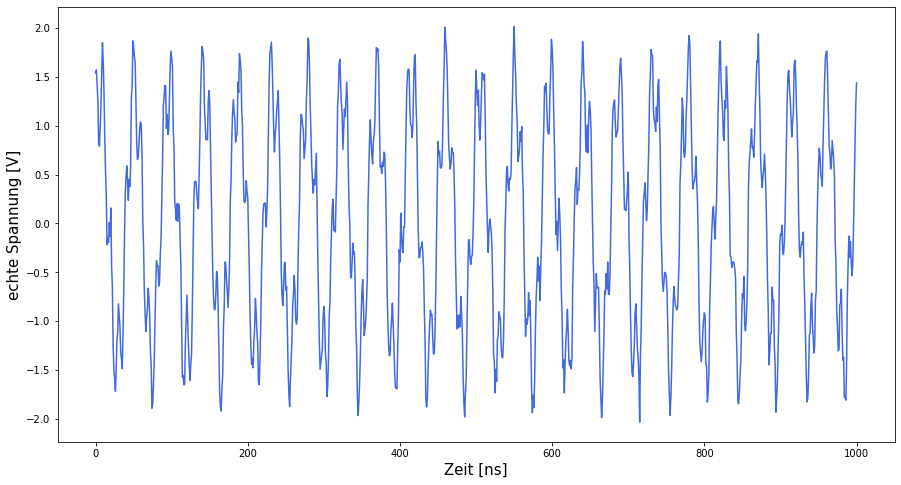

In [65]:
plt.figure(figsize=(15, 8))
plt.plot(t, x, color='royalblue', label="Spannung U (V)")
# plt.axes().set_aspect('auto', 'datalim')
plt.xlabel('Zeit [ns]', fontsize = 15)
plt.ylabel('echte Spannung [V]', fontsize = 15)
plt.show()

In [66]:
def CN(x,f):
    Xn = 0
    for n in range(N):
        Xn += x[n] * cmath.exp(-1j*2*np.pi*f*n)
    return Xn

fc = 0.022  #f_sig1

print(CN(x,fc))
#print(CN(U,-fc))

(497.6264329857791-497.27307441121155j)


## Illustration der Fourierkomponenten

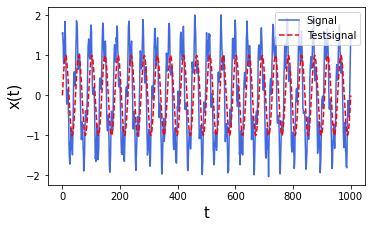

(497.6264329857791+497.27307441121155j)


In [73]:
test_signal = np.cos(2*np.pi*fc*t) + 1j*np.sin(2*np.pi*fc*t)

plt.figure(figsize=(5, 3))
plt.plot(t, x, color='royalblue', label="Signal")
plt.plot(t, np.imag(test_signal), '--', color='red', label="Testsignal")
#plt.plot(t, np.imag(x*test_signal), color='black', label="Projektion")
# plt.axes().set_aspect('auto', 'datalim')
plt.legend(loc='upper right')
plt.xlabel('t', fontsize = 15)
plt.ylabel('x(t)', fontsize = 15)
plt.tight_layout(pad=0.1)
plt.savefig('psd-fig1.pdf')
plt.show()
print(sum(x*test_signal))
# Die Fourierkomponente entspricht der Stärke der Korrelation zwischen dem Signal und dem Sinus bzw. dem Cosinus

C:\Users\uwevo\AppData\Roaming\Python\Python39\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


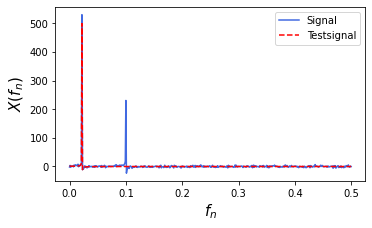

(497.6264329857791+497.27307441121155j)


In [75]:
x_signal_fft = np.fft.rfft( x )
test_signal_fft = np.fft.rfft( test_signal )
test_freqs = np.fft.rfftfreq( n = len(test_signal), d=np.diff(t)[0])
plt.figure(figsize=(5,3))
plt.plot(test_freqs,np.real( x_signal_fft), '-', color='royalblue', label="Signal")
plt.plot(test_freqs, np.real(test_signal_fft), '--',  color='red', label="Testsignal")
plt.legend(loc='upper right')
plt.xlabel(r'$f_n$', fontsize = 15)
plt.ylabel(r'$X(f_n)$', fontsize = 15)
plt.tight_layout(pad=0.1)
plt.savefig('psd-fig1_fft.pdf')
plt.show()

print(sum(x*test_signal))
# Die Fourierkomponente entspricht der Stärke der Korrelation zwischen dem Signal und dem Sinus bzw. dem Cosinus

## Wir "messen" unser Signal mit einem simulierten Analog-Digital-Konverter (ADC)

In [69]:
Delta_t = 1 # zeitl. Abstand der Messpunkte in den gewählten Einheiten: für einen Zeitvektor t mit Abständen von je 1 Nanosekunde misst unser ADC einen Datenpunkt alle Delta_t Nanosekunden
U_max = 10.0 # maximal messbarer Wert: alle grösseren Werte werden als U_max angezeigt ("clipping")
U_min = 0.001 # minimaler messbarer Spannungsunterschied der Signalwerte: Spannungsauflösung des ADC
U_noise = 0.1 # Standardabweichung des Spannungsrauschens, das dem Signal durch den Messprozess hinzigefügt wird

# Initialisierung der Messvektoren
n_mess = math.floor(N/Delta_t)-1 # Anzahl gemesener Punkte. "floor" rundet ab
n = range(n_mess) # wird für for loop benötigt, enthält 0 und n_mess als untere und obere Grenze von n
#print(n_mess)
t_mess = np.zeros(n_mess) # leerer Vektor, um die Zeitwerte zu erfassen
U_mess = np.zeros(n_mess) # leerer Vektor, um die Spannungswerte zu erfassen

for i in n:
    t_mess[i] = t[(i)*Delta_t] # jeder (i+1)*Delta_t-te Punkt wird gemessen
    U_mess[i] = np.clip(U_min*round((x[(i+1)*Delta_t]+np.random.normal(0,U_noise))/U_min,0),-U_max,U_max) # numpy.clip limitiert die maximalen Werte auf [-U_max,U_max]

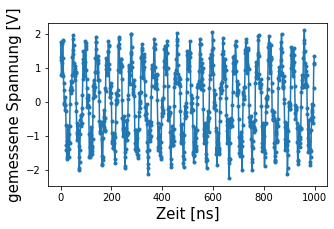

1.1304822960790002


In [70]:
plt.figure(figsize=(5,3))
plt.plot(t_mess, U_mess, zorder=2, marker='o', linestyle='-', markersize=3)
plt.xlabel('Zeit [ns]', fontsize = 15)
plt.ylabel('gemessene Spannung [V]', fontsize = 15)
plt.tight_layout(pad=0.1)

plt.savefig('psd-fig2.pdf')
plt.show()

print(np.var(U_mess)) # Varianz der Auslenkung

## Bestimmung des Spektrums

In [71]:
# Wir berechnen die PSD

f_sampling = N/N # Samplingfrequenz, gegeben durch Anzahl Samples durch Messzeit. In unserem Fall ist beides durch N gegeben

f,PSDx = scipy.signal.periodogram(U_mess,f_sampling,return_onesided=True,scaling='density')

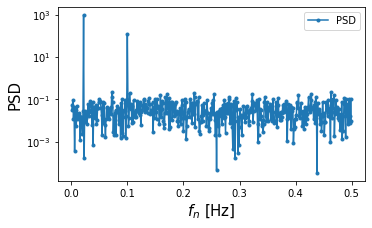

1.1304822960790024


In [76]:
########### plot PSD ##########

plt.figure(figsize=(5,3))
plt.semilogy(f[1:-1],PSDx[1:-1],label="PSD",linestyle='-',marker='o', markersize=3)
#plt.ylim([1e-5, 1e3]) # plot range in y-direction
#plt.xlim([0, 0.5])
plt.xlabel(r'$f_n$ [Hz]', fontsize=15)
plt.ylabel('PSD', fontsize=15)
plt.legend()
plt.tight_layout(pad=0.1)

plt.savefig('psd-fig3.pdf')
plt.show()

print(sum(PSDx)*(f[1]-f[0])) # numerisches Integral des Spektrums = Varianz der Auslenkung